# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer sentiment, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [6]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [7]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.8770
1980-02-01,66.9,47.9757
1980-03-01,56.5,48.4793
1980-04-01,52.7,47.0662
1980-05-01,51.7,45.6995


## Prepare Data

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [8]:
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())

### Scaling

Then we scale the transformed data to the [0,1] interval:

In [9]:
df_transformed = df_transformed.apply(minmax_scale)

### Plot original and transformed series

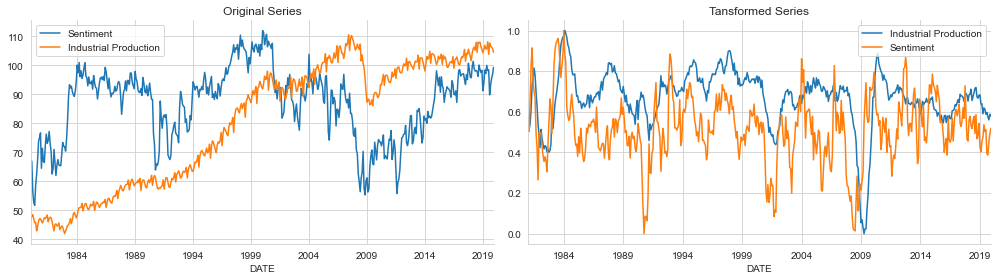

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [11]:
df.values.reshape(-1, 12, 2).shape

(40, 12, 2)

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [12]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [13]:
window_size = 18

In [14]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [15]:
X.shape, y.shape

((450, 18, 2), (450, 2))

In [16]:
df_transformed.head()

,ip,sentiment
DATE,,
1981-01-01,0.526669,0.576214
1981-02-01,0.513795,0.502513
1981-03-01,0.542863,0.670017
1981-04-01,0.613397,0.832496
1981-05-01,0.731775,0.914573


Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [17]:
test_size =24
train_size = X.shape[0]-test_size

In [18]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [19]:
X_train.shape, X_test.shape

((426, 18, 2), (24, 18, 2))

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 12 and 6 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [20]:
K.clear_session()

In [21]:
n_features = output_size = 2

In [22]:
lstm_units = 12
dense_units = 6

In [23]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])

The model has 1,268 parameters, as shown here:

In [24]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 12)                720       
_________________________________________________________________
FC (Dense)                   (None, 6)                 78        
_________________________________________________________________
Output (Dense)               (None, 2)                 14        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [25]:
rnn.compile(loss='mae', optimizer='RMSProp')

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [26]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [28]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
22/22 [==============================] - 11s 368ms/step - loss: 0.2685 - val_loss: 0.0417

Epoch 00001: val_loss improved from inf to 0.04171, saving model to results/multivariate_time_series\lstm.h5
Epoch 2/100
22/22 [==============================] - 8s 357ms/step - loss: 0.1029 - val_loss: 0.0387

Epoch 00002: val_loss improved from 0.04171 to 0.03868, saving model to results/multivariate_time_series\lstm.h5
Epoch 3/100
22/22 [==============================] - 8s 367ms/step - loss: 0.0982 - val_loss: 0.0370

Epoch 00003: val_loss improved from 0.03868 to 0.03705, saving model to results/multivariate_time_series\lstm.h5
Epoch 4/100
22/22 [==============================] - 8s 356ms/step - loss: 0.0956 - val_loss: 0.0377

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/100
22/22 [==============================] - 8s 359ms/step - loss: 0.0944 - val_loss: 0.0416

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/100
22/22 [==============================] -

22/22 [==============================] - 8s 350ms/step - loss: 0.0811 - val_loss: 0.0345

Epoch 00049: val_loss did not improve from 0.03409
Epoch 50/100
22/22 [==============================] - 8s 349ms/step - loss: 0.0816 - val_loss: 0.0359

Epoch 00050: val_loss did not improve from 0.03409
Epoch 51/100
22/22 [==============================] - 8s 354ms/step - loss: 0.0761 - val_loss: 0.0337

Epoch 00051: val_loss improved from 0.03409 to 0.03366, saving model to results/multivariate_time_series\lstm.h5
Epoch 52/100
22/22 [==============================] - 8s 356ms/step - loss: 0.0777 - val_loss: 0.0341

Epoch 00052: val_loss did not improve from 0.03366
Epoch 53/100
22/22 [==============================] - 8s 364ms/step - loss: 0.0751 - val_loss: 0.0400

Epoch 00053: val_loss did not improve from 0.03366
Epoch 54/100
22/22 [==============================] - 8s 361ms/step - loss: 0.0792 - val_loss: 0.0446

Epoch 00054: val_loss did not improve from 0.03366
Epoch 55/100
22/22 [=======

## Evaluate the Results

Training stops early after 22 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

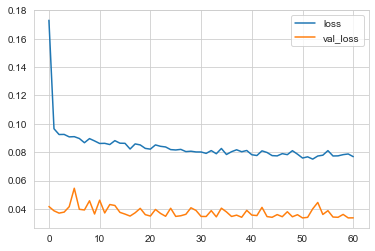

In [29]:
pd.DataFrame(result.history).plot();

In [30]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [31]:
test_mae = mean_absolute_error(y_pred, y_test)

In [32]:
print(test_mae)

0.03366098254635875


In [33]:
y_test.index

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

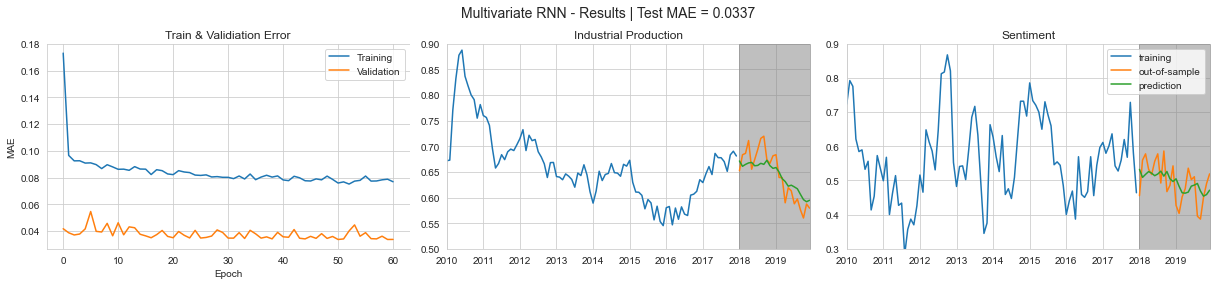

In [34]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 4))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300);